## Observations and Insights 

As seen in the bar chart 'Number of Measurements per Drug Regimen', the number of measurements taken per drug regimen varies, ranging from 156 to 230 measurements. This is due to the general unevenness of this data set. Aside from the duplicate values for a mouse, which were deleted, there are also missing values, as can be seen in the value counts on the no_dups_df (all the drug regimens) and top_regs_df (the four target drugs). For example, in the Capomulin data within top_regs_df, which shows all the data associated with that drug, there are 25 measurements for time points 0-10, but only 24 measurements for time point 15, and 21 measurements for time point 45. As this study concerns cancers, it is possible that the mice IDs with missing values relate to mice that died before reaching the end time point. If so, that data would still be useful, and should not just be discarded. But as will be discussed later, the number of measurements could possibly skew comparisons of analysis across treatments.  

The boxplots of the four target drug regimens show a marked difference between the final average tumor volume of Ramicane and Capomulin, and Infobinol and Ceftamin. Each mouse in the study started with the same tumor volume (see start_values_df output), so the difference in end values across the four regimens could suggest a difference in efficacy in reducing tumor size, with Ramicane and Capomulin being more successful, since they reduced average tumor size from 45 mm3 to 36.56 and 38.13 mm3 respectively. However, as mentioned above, not all mouse IDs have the same endpoint. The distribution of end point values in each regimen show that the majority of values for Ramicane and Capomulin are at timepoint 45, while less than half of the values for Infobinol and Ceftamin are from timepoint 45. Given that those regimens have more values from earlier end points, it makes sense that those regimens would show larger tumor measurements, even if they were equally as effective in tumor reduction. However, if looking at only the data with endpoint 45, the values for Infobinol and Ceftamin still remain higher (65.76 and 64.13) than those for Ramicane and Capomulin (34.96, 36.24), suggesting that Infobinol and Ceftamin may in fact be less effective in tumor reduction. Furthermore, the large amounts of lower endpoint values, if those do represent mouse deaths, could suggest that not only are they ineffective in reducing tumor size, the tumors on those regimens appear to conduce towards death. The sample sizes are small (25 values for each regimen), so repetition of this study with more research subjects is recommended. 

Conducting a quantile analysis on the final tumor volumes of the four target treatments only exposed one potential outlier, which was in the Infubinol regime. The data point was approximately 36.321 mm3, which is about 0.5 mm3 under the lower bound. The data point was from a mouse ID that ended at time point 5; other mouse IDs that ended at timepoint 5 also show lower values (in the 40s mm3), although not as low as the potential outlier. This data point being identified as a possible outlier shows the problems of comparing data points at different time points: while they are all end points, they are different stages in a progression. Nonetheless, the 36.321 mm3 still stands apart from the other data points within the Infubinol set, even if comparing only those values that end at time point 5. Given the other errors in the data set (duplicate values), the 36.321 mm3 value could be a mis-entry, or it could be from a mouse with a serious cancer yet small tumors that died. 

There appears to be a strong positive correlation between average tumor volume and mouse weight in the Capomulin regimen: as mouse weight increases, the tumor's weight also increases. One might think that tumors generally take up the same proportion of an animal's body, so it would make sense for the tumor volume to rise along with the mouse weight. However, if the same linear regression is done for the other three regimens, the same relationship is not consistently seen. For Ramicane, there is a similarly strong positive correlation between tumor volume and mouse weight; for Infubinol, there appears to be a weak negative correlation (correlation coefficient: -0.368); but for Ceftamin there seems to be very little liklihood of a correlation (the correlation coefficient is very low, approx. 0.0006). The number of values for the Infubinol and Ceftamin subsets for tumor volume vs. weight are smaller than the Capomulin and Ramicane ones by about 50 values: it could be that the shorter subsets made the extreme values have more of an effect on the linear regression, causing the representation of any possible correlation to be weaker. Although all four data sets have at least 170 values, the averages per weight amount are what is being graphed, leading to there only being 9 points graphed for Ramicane and Capomulin, and 7 for Infobinol and Ceftamin, which furthermore amplifies the effect of the difference in data set numbers. The Infobinol and Ceftamin subsets have the same number of values, however, so comparison between those two could be more fruitful. In fact, there is a correlation difference between the two, albeit a weak one; potentially the negative correlation between mouse weight and tumor volume under Infubinol could suggest that Infubinol is more effective on heavier mice. 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import random

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata_df = pd.read_csv(mouse_metadata_path)
study_results_df = pd.read_csv(study_results_path)

# Combine the data into a single dataset
merged_df = pd.merge(mouse_metadata_df, study_results_df, on='Mouse ID', how='outer')
# Display the data table for preview
merged_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [2]:
mask_start = merged_df['Timepoint'] == 0
start_values_df = merged_df.loc[mask_start, :]
start_values_df['Tumor Volume (mm3)'].value_counts()

45.0    250
Name: Tumor Volume (mm3), dtype: int64

In [3]:
#renaming the col Timepoint to reflect what unit it uses
merged_df = merged_df.rename(columns={'Timepoint': 'Timepoint (Days)'})
merged_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint (Days),Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [4]:
# Checking the number of mice.
unique_mice_list = merged_df['Mouse ID'].unique()
num_unique_mice = len(unique_mice_list)
num_unique_mice

249

In [5]:
#creating a new df to clean
no_dups_df = merged_df.copy()

In [6]:
dup_index = []
dup_mice = []
def duplicate_checker_dups(mID):
    mask = merged_df['Mouse ID'] == mID
    only_mID = merged_df.loc[mask, :]
    dups = only_mID.duplicated(subset='Timepoint (Days)')
    end_index = len(dups)
    global dup_index
    dup_index = dups[dups == True].index[0: end_index]
    for n in dup_index:
        a_dup_mouse = merged_df.iloc[n, 0]
        if a_dup_mouse not in dup_mice:
            dup_mice.append(a_dup_mouse)
        global no_dups_df
        no_dups_df.drop(n, inplace=True)
for x in unique_mice_list:
    duplicate_checker_dups(x)
print(f'number of mice in the duplicates list: {len(dup_mice)}')
#since end_mice_list has only one value, there's only one mouse with duplicates, index=0
dup_mouse = dup_mice[0] 

number of mice in the duplicates list: 1


In [7]:
no_dups_df['Timepoint (Days)'].value_counts()

0     249
5     237
10    222
15    206
20    194
25    183
30    171
35    154
40    142
45    130
Name: Timepoint (Days), dtype: int64

In [8]:
#info on duplicate mouse
#info on that mouse
dup_mask_check = no_dups_df['Mouse ID'] == dup_mouse
dup_mouse_info = no_dups_df.loc[dup_mask_check, :]
dup_mouse_info

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint (Days),Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
912,g989,Propriva,Female,21,26,10,51.745156,0
914,g989,Propriva,Female,21,26,15,51.325852,1
916,g989,Propriva,Female,21,26,20,55.326122,1
918,g989,Propriva,Female,21,26,25,56.045564,1
919,g989,Propriva,Female,21,26,30,59.082294,1
920,g989,Propriva,Female,21,26,35,62.570880,2


In [9]:
#for if needing to drop the whole mouse - drop lines 14 and 15 in 4th code block
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
#getting indices for the mouse with repeats
#index_dups = dup_info_df.index.values
#dropping the rows with the repeat mouse
#for i in index_dups:
    #no_dups_df.drop(i, inplace=True) 
#no_dups_df.head(20)

In [10]:
# Checking the number of mice in the clean DataFrame.
#checking length of new df mouse list
unique_mice_list_new = no_dups_df['Mouse ID'].unique()
num_unique_mice_new = len(unique_mice_list_new)

#old list
original_mice_list = merged_df['Mouse ID'].unique()
num_original_mice = len(original_mice_list)
num_unique_mice_new, num_original_mice

(249, 249)

## Summary Statistics

In [11]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary dataframe.
no_dups_df_grouped = no_dups_df.groupby('Drug Regimen')
avg_tumour_size = no_dups_df_grouped['Tumor Volume (mm3)'].mean() 
avg_tumour_size = avg_tumour_size.rename('mean tumor vol')
median_tumour_size = no_dups_df_grouped['Tumor Volume (mm3)'].median()
median_tumour_size = median_tumour_size.rename('median tumor vol')
var_tumour = no_dups_df_grouped['Tumor Volume (mm3)'].var(ddof=0)
var_tumour = var_tumour.rename('variance tumor vol')
std_tumour = no_dups_df_grouped['Tumor Volume (mm3)'].std(ddof=0)
std_tumour = std_tumour.rename('st.dev tumor vol')
#SEM is unbiased standard error of the mean
sem_tumour = no_dups_df_grouped['Tumor Volume (mm3)'].sem(ddof=0)
sem_tumour = sem_tumour.rename('SEM tumor vol')

summary_df = pd.concat([avg_tumour_size, median_tumour_size, var_tumour, std_tumour, sem_tumour], axis=1)
summary_df

,mean tumor vol,median tumor vol,variance tumor vol,st.dev tumor vol,SEM tumor vol
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.839296,4.983904,0.328629
Ceftamin,52.591172,51.776157,39.069446,6.250556,0.468499
Infubinol,52.884795,51.820584,42.886388,6.548770,0.490851
Ketapril,55.235638,53.698743,68.188930,8.257659,0.602252
Naftisol,54.331565,52.509285,65.817708,8.112811,0.594860
Placebo,54.033581,52.288934,60.830138,7.799368,0.579722
Propriva,52.393463,50.909965,42.862273,6.546928,0.524174
Ramicane,40.216745,40.673236,23.383692,4.835669,0.320250
Stelasyn,54.233149,52.431737,59.122106,7.689090,0.571526


In [12]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Using the aggregation method, produce the same summary statistics in a single line
summstats = no_dups_df_grouped['Tumor Volume (mm3)'].agg(['mean', 'median', 'var', 'std', 'sem']).rename(columns = {'mean': 'mean tumor vol', 'median': 'median tumor vol', 'var': 'variance tumor vol', 'std': 'st.dev tumor vol', 'sem': 'SEM tumor vol'})
summstats

,mean tumor vol,median tumor vol,variance tumor vol,st.dev tumor vol,SEM tumor vol
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.393463,50.909965,43.138803,6.568014,0.525862
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

<AxesSubplot:title={'center':'Number of Measurements per Drug Regimen'}, xlabel='Drug Regimen', ylabel='Number of Measurements'>

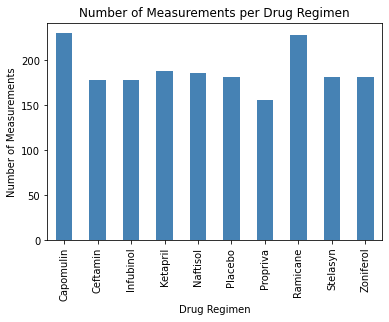

In [13]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pandas.
no_dups_df_grouped = no_dups_df.groupby('Drug Regimen')
num_measurements_df = pd.DataFrame(no_dups_df_grouped['Drug Regimen'].count()).rename(columns=({'Drug Regimen': 'Number of Measurements'}))

num_measurements_df.plot(kind='bar', title='Number of Measurements per Drug Regimen', color='steelblue', legend=None, ylabel='Number of Measurements')

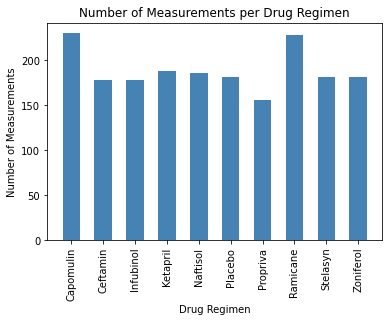

In [14]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pyplot.
x_axis = num_measurements_df.index
y_axis = num_measurements_df['Number of Measurements']

plt.xlabel('Drug Regimen')
plt.ylabel('Number of Measurements')
plt.title('Number of Measurements per Drug Regimen')
plt.bar(x_axis, y_axis, width=0.55, color='steelblue')
plt.xticks(x_axis, rotation=90)
plt.show()

In [15]:
print(f'Lowest number of measurements: {num_measurements_df.min()}')
print(f'Highest number of measurements: {num_measurements_df.max()}')
num_measurements_df.describe()

Lowest number of measurements: Number of Measurements    156
dtype: int64
Highest number of measurements: Number of Measurements    230
dtype: int64


,Number of Measurements
count,10.000000
mean,188.800000
std,22.899782
min,156.000000
25%,178.750000
50%,181.500000
75%,187.500000
max,230.000000


<AxesSubplot:title={'center':'Gender Distribution of Mice in Experiment'}>

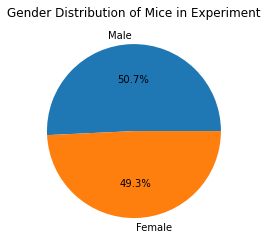

In [16]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
mice_sex = no_dups_df['Sex'].value_counts()
mice_sex.plot(kind='pie', title='Gender Distribution of Mice in Experiment', autopct='%1.1f%%', label='')

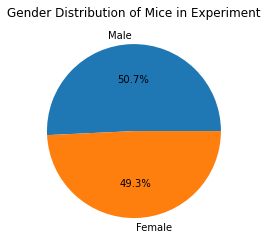

In [17]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
values = mice_sex
labels = mice_sex.index

plt.pie(mice_sex, labels=labels, autopct='%1.1f%%')
plt.title('Gender Distribution of Mice in Experiment')
plt.show()

## Quartiles, Outliers and Boxplots

In [18]:
no_dups_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint (Days),Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [45]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
#applying a mask only for the 4 drugs we want
drugsmask = (no_dups_df["Drug Regimen"] == "Capomulin") | (no_dups_df["Drug Regimen"] == "Ramicane") | (no_dups_df["Drug Regimen"] == "Infubinol") | (no_dups_df["Drug Regimen"] == "Ceftamin")
#saving that mask to a new df
top_drugs_df = no_dups_df.loc[drugsmask, :]
#grouping that df by mouse ID
mIDgroup_df = top_drugs_df.groupby('Mouse ID')
#creating a series that has mouse ID as index, max timepoint for each ID as values
sub_mID = mIDgroup_df['Timepoint (Days)'].max()

#empty lists for appending mouse IDs and last timepoint
mIDlist = []
lasttimelist = []

#for loop to append    
for x in range(0, len(sub_mID)):
    mIDlist.append(sub_mID.index[x])
    lasttimelist.append(sub_mID[x])

#empty lists for appending the name of the regime and tumour vol per mouseID/last time    
regime_names = []
tumour_vols = []

#def function for filling regime/tumour values
def get_regime_tumour(name, day):
    #mask for only getting the row of the last timepoint for one mouseID
    mask = (top_drugs_df['Mouse ID'] == name) & (top_drugs_df['Timepoint (Days)'] == day) 
    top_drugs_df.loc[mask, :]
    #appending the info, formatting it so the index and other text doesn't get saved to it
    regime_names.append(str(top_drugs_df.loc[mask, 'Drug Regimen']).split("\nName:")[0].split("    ")[1])
    tumour_vols.append(float(str(top_drugs_df.loc[mask, 'Tumor Volume (mm3)']).split(' ')[4].rstrip('\nName:')))

#calling the function for each mouse ID
for x in range(0, (len(mIDlist))):
    mid = mIDlist[x]
    time = lasttimelist[x]
    get_regime_tumour(mid, time)

#creating series to hold the list info
mid_series = pd.Series(mIDlist, dtype='object')
lasttime_series = pd.Series(lasttimelist, dtype='object')
regime_series = pd.Series(regime_names, dtype='object')
tumour_series = pd.Series(tumour_vols, dtype='float')

#combining the series to make a new df
top_regimes_df = pd.DataFrame({'Mouse ID': mid_series, 'Last Time': lasttime_series, 'Drug Regimen': regime_series, 'Tumor Volume (mm3)': tumour_series})
top_regimes_df.head()

,Mouse ID,Last Time,Drug Regimen,Tumor Volume (mm3)
0,a203,45,Infubinol,67.973419
1,a251,45,Infubinol,65.525743
2,a275,45,Ceftamin,62.999356
3,a411,45,Ramicane,38.407618
4,a444,45,Ramicane,43.047543


In [46]:
top_regs = top_drugs_df.groupby('Drug Regimen')
top_regs['Timepoint (Days)'].value_counts()

Drug Regimen  Timepoint (Days)
Capomulin     0                   25
              5                   25
              10                  25
              15                  24
              20                  23
              25                  22
              30                  22
              35                  22
              40                  21
              45                  21
Ceftamin      0                   25
              5                   21
              10                  20
              15                  19
              20                  18
              25                  18
              30                  16
              35                  14
              40                  14
              45                  13
Infubinol     0                   25
              5                   25
              10                  21
              15                  21
              20                  20
              25                  18
       

In [21]:
#test of the values that have 45 mm3 as their last tumour vol - they all have T0 as their only data point
idformask = ['b447', 't573', 'u153','x226']

for testid in idformask:
    mask2 = no_dups_df['Mouse ID'] == testid
    test_df = no_dups_df.loc[mask2, :]
    print(test_df)
#looking at tum vol for all starting points - they are all 45
mask3 = no_dups_df['Timepoint (Days)'] == 0
test3_df = no_dups_df.loc[mask3, :]
test3_df['Tumor Volume (mm3)'].unique()

    Mouse ID Drug Regimen   Sex  Age_months  Weight (g)  Timepoint (Days)  \
594     b447     Ceftamin  Male           2          30                 0   

     Tumor Volume (mm3)  Metastatic Sites  
594                45.0                 0  
     Mouse ID Drug Regimen     Sex  Age_months  Weight (g)  Timepoint (Days)  \
1551     t573     Ceftamin  Female          15          27                 0   

      Tumor Volume (mm3)  Metastatic Sites  
1551                45.0                 0  
     Mouse ID Drug Regimen     Sex  Age_months  Weight (g)  Timepoint (Days)  \
1583     u153     Ceftamin  Female          11          25                 0   

      Tumor Volume (mm3)  Metastatic Sites  
1583                45.0                 0  
     Mouse ID Drug Regimen   Sex  Age_months  Weight (g)  Timepoint (Days)  \
1743     x226     Ceftamin  Male          23          28                 0   

      Tumor Volume (mm3)  Metastatic Sites  
1743                45.0                 0  


array([45.])

In [22]:
#creating new dfs for each treatment
#masking the top_regimes_df for each drug regime name
#treatments = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

drug_mask_ca = top_regimes_df['Drug Regime'] == 'Capomulin'
ca_df = pd.DataFrame(top_regimes_df.loc[drug_mask_ca, :])

drug_mask_ra = top_regimes_df['Drug Regime'] == 'Ramicane'
ra_df = pd.DataFrame(top_regimes_df.loc[drug_mask_ra, :])

drug_mask_in = top_regimes_df['Drug Regime'] == 'Infubinol'
in_df = pd.DataFrame(top_regimes_df.loc[drug_mask_in, :])

drug_mask_ce = top_regimes_df['Drug Regime'] == 'Ceftamin'
ce_df = pd.DataFrame(top_regimes_df.loc[drug_mask_ce, :])

In [23]:
print(ca_df['Last Time'].value_counts())
print(len(ca_df))
ca_df

45    21
15     1
20     1
35     1
10     1
Name: Last Time, dtype: int64
25


,Mouse ID,Last Time,Drug Regime,Tumor Volume (mm3)
9,b128,45,Capomulin,38.982878
12,b742,45,Capomulin,38.939633
24,f966,20,Capomulin,30.485985
25,g288,45,Capomulin,37.074024
26,g316,45,Capomulin,40.159220
32,i557,45,Capomulin,47.685963
33,i738,45,Capomulin,37.311846
34,j119,45,Capomulin,38.125164
35,j246,35,Capomulin,38.753265
45,l509,45,Capomulin,41.483008


In [24]:
mask_45 = ca_df['Last Time'] == 45
ca_45_ends = ca_df.loc[mask_45, :]
ca_45_ends.mean()

Last Time             45.000000
Tumor Volume (mm3)    36.236114
dtype: float64

In [25]:
print(ra_df['Last Time'].value_counts())
print(len(ra_df))
ra_df

45    20
30     2
5      1
35     1
15     1
Name: Last Time, dtype: int64
25


,Mouse ID,Last Time,Drug Regime,Tumor Volume (mm3)
3,a411,45,Ramicane,38.407618
4,a444,45,Ramicane,43.047543
5,a520,45,Ramicane,38.810366
7,a644,45,Ramicane,32.978522
16,c458,30,Ramicane,38.342008
17,c758,45,Ramicane,33.397653
19,d251,45,Ramicane,37.311236
21,e662,45,Ramicane,40.659006
27,g791,45,Ramicane,29.128472
29,i177,45,Ramicane,33.562402


In [26]:
mask_45 = ra_df['Last Time'] == 45
ra_45_ends = ra_df.loc[mask_45, :]
ra_45_ends.mean()

Last Time             45.000000
Tumor Volume (mm3)    34.955595
dtype: float64

In [27]:
print(in_df['Last Time'].value_counts())
print(len(in_df))
in_df

45    9
30    5
5     4
20    2
35    2
15    1
25    1
40    1
Name: Last Time, dtype: int64
25


,Mouse ID,Last Time,Drug Regime,Tumor Volume (mm3)
0,a203,45,Infubinol,67.973419
1,a251,45,Infubinol,65.525743
6,a577,30,Infubinol,57.031862
8,a685,45,Infubinol,66.083066
14,c139,45,Infubinol,72.226731
15,c326,5,Infubinol,36.321346
18,c895,30,Infubinol,60.969711
20,e476,45,Infubinol,62.435404
22,f345,45,Infubinol,60.918767
31,i386,40,Infubinol,67.289621


In [28]:
mask_45 = in_df['Last Time'] == 45
in_45_ends = in_df.loc[mask_45, :]
in_45_ends.mean()

Last Time             45.000000
Tumor Volume (mm3)    65.755562
dtype: float64

In [29]:
print(ce_df['Last Time'].value_counts())
print(len(ce_df))
ce_df

45    13
0      4
30     2
25     2
15     1
10     1
40     1
5      1
Name: Last Time, dtype: int64
25


,Mouse ID,Last Time,Drug Regime,Tumor Volume (mm3)
2,a275,45,Ceftamin,62.999356
10,b447,0,Ceftamin,45.000000
11,b487,25,Ceftamin,56.057749
13,b759,30,Ceftamin,55.742829
23,f436,15,Ceftamin,48.722078
28,h531,5,Ceftamin,47.784682
36,j296,45,Ceftamin,61.849023
39,k210,45,Ceftamin,68.923185
43,l471,45,Ceftamin,67.748662
44,l490,30,Ceftamin,57.918381


In [30]:
mask_45 = ce_df['Last Time'] == 45
ce_45_ends = ce_df.loc[mask_45, :]
ce_45_ends.mean()

Last Time             45.000000
Tumor Volume (mm3)    64.132421
dtype: float64

In [58]:
treatments = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']
df_list = [ca_df, ra_df, in_df, ce_df]
outlier_list = []

for x in range(0, len(df_list)):
    treatment_name = treatments[x]
    reg_df = df_list[x]
    quants = reg_df['Tumor Volume (mm3)'].quantile([0.25,0.5,0.75])
    q1 = quants.iloc[0]
    reg_mean = quants.iloc[1]
    q3 = quants.iloc[2]
    iqr = q3 - q1
    upperbound = q3 + (1.5 * iqr)
    lowerbound = q1 - (1.5 * iqr)
    mask = (reg_df ["Tumor Volume (mm3)"] > upperbound) | (reg_df ["Tumor Volume (mm3)"] < lowerbound)
    outliers = reg_df.loc[mask, :]  
    outlier_list.append(outliers)
#outlier_list
#outlier_list[map(outlier_list, dim(x)[1]) > 0]
non_zero_outlier_list = []
for df in outlier_list:
    if len(df) > 0:
        non_zero_outlier_list.append(df)
non_zero_outlier_list    

[   Mouse ID Last Time Drug Regime  Tumor Volume (mm3)
 15     c326         5   Infubinol           36.321346]

In [49]:
treatments = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']
df_list = [ca_df, ra_df, in_df, ce_df]
outlier_list = []

for x in range(0, len(df_list)):
    treatment_name = treatments[x]
    reg_df = df_list[x]
    #print(reg_df)
    quants = reg_df['Tumor Volume (mm3)'].quantile([0.25,0.5,0.75])
    q1 = quants.iloc[0]
    reg_mean = quants.iloc[1]
    q3 = quants.iloc[2]
    iqr = q3 - q1
    upperbound = q3 + (1.5 * iqr)
    lowerbound = q1 - (1.5 * iqr)
    print(f'{treatment_name}:')
    print(quants)
    print(f'Q1: {q1}, Q3: {q3}')
    print(f'iqr: {iqr}')
    print(f'lower bound: {lowerbound}, upper bound: {upperbound}')
    mask = (reg_df ["Tumor Volume (mm3)"] > upperbound) | (reg_df ["Tumor Volume (mm3)"] < lowerbound)
    outliers = reg_df.loc[mask, :]  
    outlier_list.append(outliers)
    print(f'Potential outliers for {treatment_name} would be below {lowerbound} or above {upperbound}. There are {len(outliers)} potential outliers in the dataset.')
    print('__________________________')
non_zero_outlier_list = []
for df in outlier_list:
    if len(df) > 0:
        non_zero_outlier_list.append(df)

Capomulin:
0.25    32.377357
0.50    38.125164
0.75    40.159220
Name: Tumor Volume (mm3), dtype: float64
Q1: 32.377357, Q3: 40.15922
iqr: 7.781862999999994
lower bound: 20.704562500000012, upper bound: 51.832014499999985
Potential outliers for Capomulin would be below 20.704562500000012 or above 51.832014499999985. There are 0 potential outliers in the dataset.
__________________________
Ramicane:
0.25    31.560470
0.50    36.561652
0.75    40.659006
Name: Tumor Volume (mm3), dtype: float64
Q1: 31.56047, Q3: 40.659006
iqr: 9.098536
lower bound: 17.912666, upper bound: 54.30681
Potential outliers for Ramicane would be below 17.912666 or above 54.30681. There are 0 potential outliers in the dataset.
__________________________
Infubinol:
0.25    54.048608
0.50    60.165180
0.75    65.525743
Name: Tumor Volume (mm3), dtype: float64
Q1: 54.048608, Q3: 65.525743
iqr: 11.477135000000004
lower bound: 36.832905499999995, upper bound: 82.74144550000001
Potential outliers for Infubinol would be 

,Mouse ID,Last Time,Drug Regime,Tumor Volume (mm3)


In [32]:
ca_xaxis = ca_df.iloc[:, 3]
ca_xaxis

9     38.982878
12    38.939633
24    30.485985
25    37.074024
26    40.159220
32    47.685963
33    37.311846
34    38.125164
35    38.753265
45    41.483008
49    38.846876
51    28.430964
53    33.329098
64    46.539206
65    32.377357
68    41.581521
70    23.343598
72    40.728578
73    34.455298
78    31.023923
82    40.658124
83    39.952347
88    36.041047
90    28.484033
96    31.896238
Name: Tumor Volume (mm3), dtype: float64

Text(0.5, 1.0, 'Drug Regimen Final Tumor Size ')

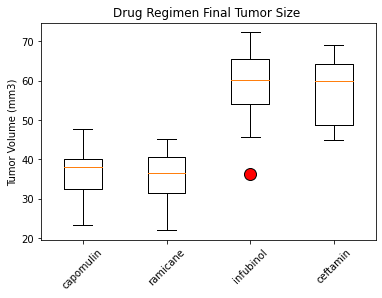

In [62]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
#'Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin'

ca_xaxis = ca_df.iloc[:, 3]
ra_xaxis = ra_df.iloc[:, 3]
in_xaxis = in_df.iloc[:, 3]
ce_xaxis = ce_df.iloc[:, 3]
regimens_dict = {'capomulin': ca_xaxis, 'ramicane': ra_xaxis, 'infubinol': in_xaxis, 'ceftamin': ce_xaxis}

styling_outliers = dict(markerfacecolor='red', marker='o', markersize=12)
fig, ax = plt.subplots()
ax.boxplot(regimens_dict.values(), flierprops=styling_outliers)
ax.set_xticklabels(regimens_dict.keys(), rotation=45)
ax.set_ylabel('Tumor Volume (mm3)')
ax.set_title('Drug Regimen Final Tumor Size ')

## Line and Scatter Plots

In [34]:
#list comprehension to get a random mouse ID from all the mice on the Capomulin regime
listcamice = [value for value in ca_df.iloc[: , 0]]

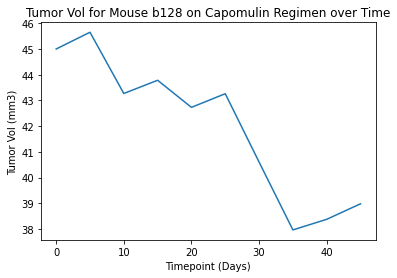

In [35]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin
mouseID = random.choice(listcamice)
capmousemask = (no_dups_df['Drug Regimen'] == 'Capomulin') & (no_dups_df['Mouse ID'] == mouseID)
only_cap_mouse = no_dups_df.loc[capmousemask, :]   

x_axis = only_cap_mouse.iloc[:, 5]
y_axis = only_cap_mouse.iloc[:, 6]


plt.plot(x_axis, y_axis)
plt.xlabel('Timepoint (Days)')
plt.ylabel('Tumor Vol (mm3)')
plt.title(f'Tumor Vol for Mouse {mouseID} on Capomulin Regimen over Time')
plt.show()

y = 0.895x + 22.764
correlation coefficient: 0.950524396185527


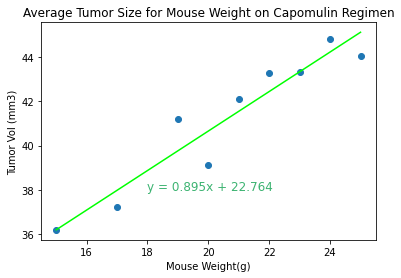

In [36]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen
capmask = (no_dups_df['Drug Regimen'] == 'Capomulin')
only_cap = no_dups_df.loc[capmask, :]  
only_cap_grouped = only_cap.groupby('Weight (g)')
avg_tum_vol = only_cap_grouped['Tumor Volume (mm3)'].mean().reset_index(drop=False)

x_axis_weight = avg_tum_vol.iloc[:, 0]
y_axis_vol = avg_tum_vol.iloc[:, 1]

plt.scatter(x_axis_weight, y_axis_vol)
plt.xlabel('Mouse Weight(g)')
plt.ylabel('Tumor Vol (mm3)')
plt.title('Average Tumor Size for Mouse Weight on Capomulin Regimen')
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis_weight, y_axis_vol)
display_line_eq = f'y = {round(slope, 3)}x + {round(intercept, 3)}'
lin_reg_mod = (slope * x_axis_weight) + intercept
print(display_line_eq)
print(f'correlation coefficient: {rvalue}')
plt.plot(x_axis_weight, lin_reg_mod, color='lime')
plt.annotate(display_line_eq, (18,38),fontsize=12,color="mediumseagreen")
plt.show()

In [37]:
len(only_cap)

230

y = 0.782x + 24.637
correlation coefficient: 0.9415006250247517


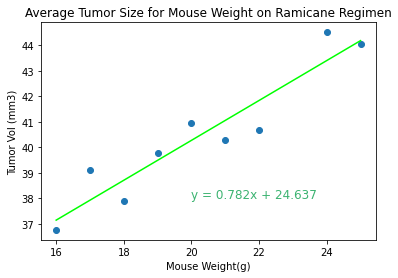

In [38]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Ramicane regimen
ramask = (no_dups_df['Drug Regimen'] == 'Ramicane')
only_ra = no_dups_df.loc[ramask, :]  
only_ra_grouped = only_ra.groupby('Weight (g)')
avg_tum_vol = only_ra_grouped['Tumor Volume (mm3)'].mean().reset_index(drop=False)

x_axis_weight = avg_tum_vol.iloc[:, 0]
y_axis_vol = avg_tum_vol.iloc[:, 1]

plt.scatter(x_axis_weight, y_axis_vol)
plt.xlabel('Mouse Weight(g)')
plt.ylabel('Tumor Vol (mm3)')
plt.title('Average Tumor Size for Mouse Weight on Ramicane Regimen')
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis_weight, y_axis_vol)
display_line_eq = f'y = {round(slope, 3)}x + {round(intercept, 3)}'
lin_reg_mod = (slope * x_axis_weight) + intercept
print(display_line_eq)
print(f'correlation coefficient: {rvalue}')
plt.plot(x_axis_weight, lin_reg_mod, color='lime')
plt.annotate(display_line_eq, (20,38),fontsize=12,color="mediumseagreen")
plt.show()

In [39]:
len(only_ra)

228

y = -0.304x + 61.82
correlation coefficient: -0.368421056071612


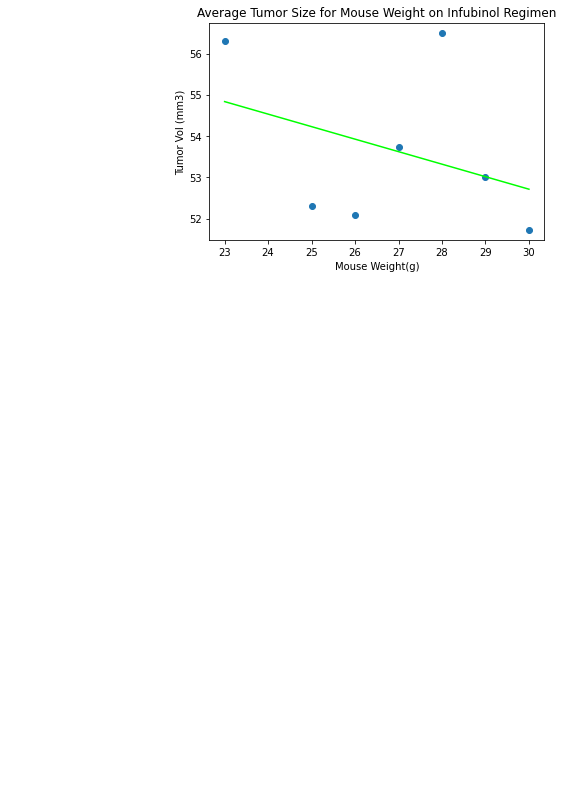

In [40]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Infubinol regimen
infmask = (no_dups_df['Drug Regimen'] == 'Infubinol')
only_inf = no_dups_df.loc[infmask, :]  
only_inf_grouped = only_inf.groupby('Weight (g)')
avg_tum_vol = only_inf_grouped['Tumor Volume (mm3)'].mean().reset_index(drop=False)

x_axis_weight = avg_tum_vol.iloc[:, 0]
y_axis_vol = avg_tum_vol.iloc[:, 1]

plt.scatter(x_axis_weight, y_axis_vol)
plt.xlabel('Mouse Weight(g)')
plt.ylabel('Tumor Vol (mm3)')
plt.title('Average Tumor Size for Mouse Weight on Infubinol Regimen')
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis_weight, y_axis_vol)
display_line_eq = f'y = {round(slope, 3)}x + {round(intercept, 3)}'
lin_reg_mod = (slope * x_axis_weight) + intercept
print(display_line_eq)
print(f'correlation coefficient: {rvalue}')
plt.plot(x_axis_weight, lin_reg_mod, color='lime')
plt.annotate(display_line_eq, (18,38),fontsize=12,color="mediumseagreen")
plt.show()

In [41]:
len(only_inf)

178

y = 0.0x + 52.405
correlation coefficient: 0.0005738920945099235


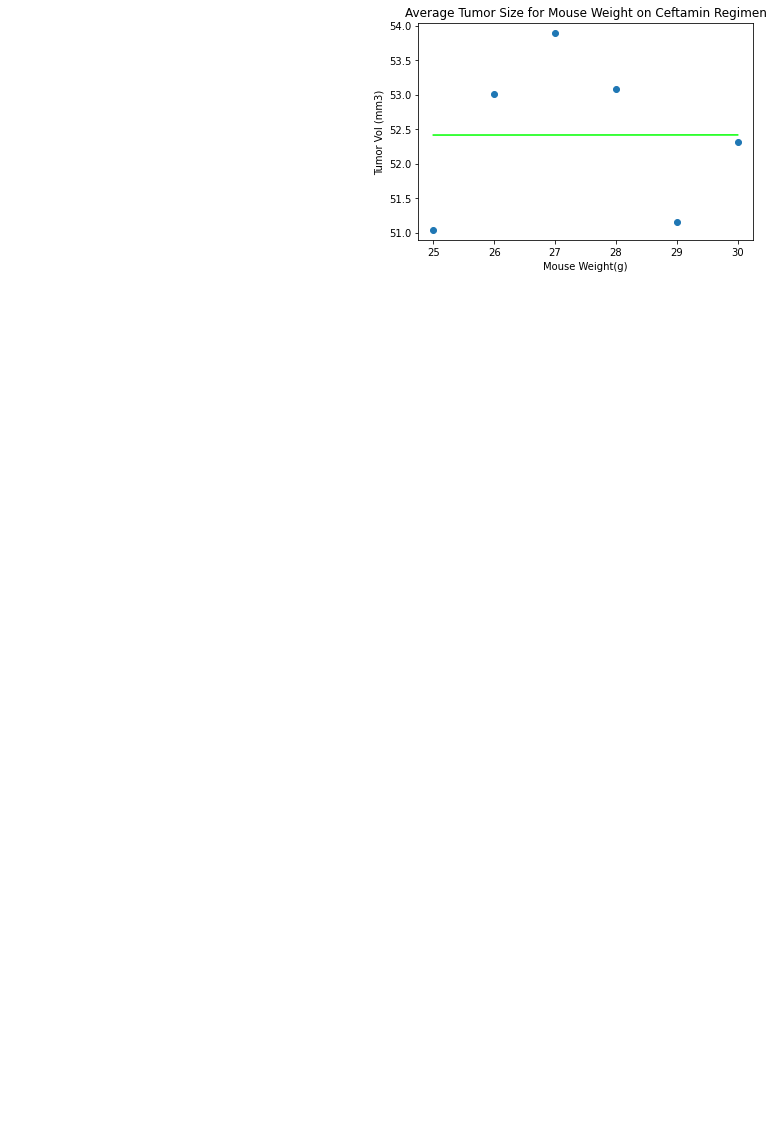

In [42]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen
cemask = (no_dups_df['Drug Regimen'] == 'Ceftamin')
only_ce = no_dups_df.loc[cemask, :]  
only_ce_grouped = only_ce.groupby('Weight (g)')
avg_tum_vol = only_ce_grouped['Tumor Volume (mm3)'].mean().reset_index(drop=False)

x_axis_weight = avg_tum_vol.iloc[:, 0]
y_axis_vol = avg_tum_vol.iloc[:, 1]

plt.scatter(x_axis_weight, y_axis_vol)
plt.xlabel('Mouse Weight(g)')
plt.ylabel('Tumor Vol (mm3)')
plt.title('Average Tumor Size for Mouse Weight on Ceftamin Regimen')
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis_weight, y_axis_vol)
display_line_eq = f'y = {round(slope, 3)}x + {round(intercept, 3)}'
lin_reg_mod = (slope * x_axis_weight) + intercept
print(display_line_eq)
print(f'correlation coefficient: {rvalue}')
plt.plot(x_axis_weight, lin_reg_mod, color='lime')
plt.annotate(display_line_eq, (18,38),fontsize=12,color="mediumseagreen")
plt.show()

In [43]:
len(only_ce)

178

## Correlation and Regression
(see above for linear regression)